In [3]:
# -------------------------------------------------
#
# This notebook tests the modified spaCy NER model that is trained on Land Registration Act on Kenyan gazettes.
# The test sets are randomly selected gazettes.
#
# -------------------------------------------------

## Testing plan

This notebook tests the modified spaCy NER model. The model was trained on custom and default labels using ~11000 gazette sections. The custom labels include entities such as "OWNER ADDRESS" and "LAND TITLE" while the default labels include "PERSON" and "LOC" (also known as Location). We will compare the performance of our modified model vs the default model with respect to the entities we care about the most which are:

* PERSON
* ID
* OWNER ADDRESS
* OWNERSHIP STATUS
* LAND SIZE
* DISTRICT
* LAND REGISTRATION
* DEED STATUS

We recommend creating a table with these entities as columns with each test section as a row to evaluate the True Positive, False Positive, and False Negative rate for each test. Here is a sample table we used for our test.

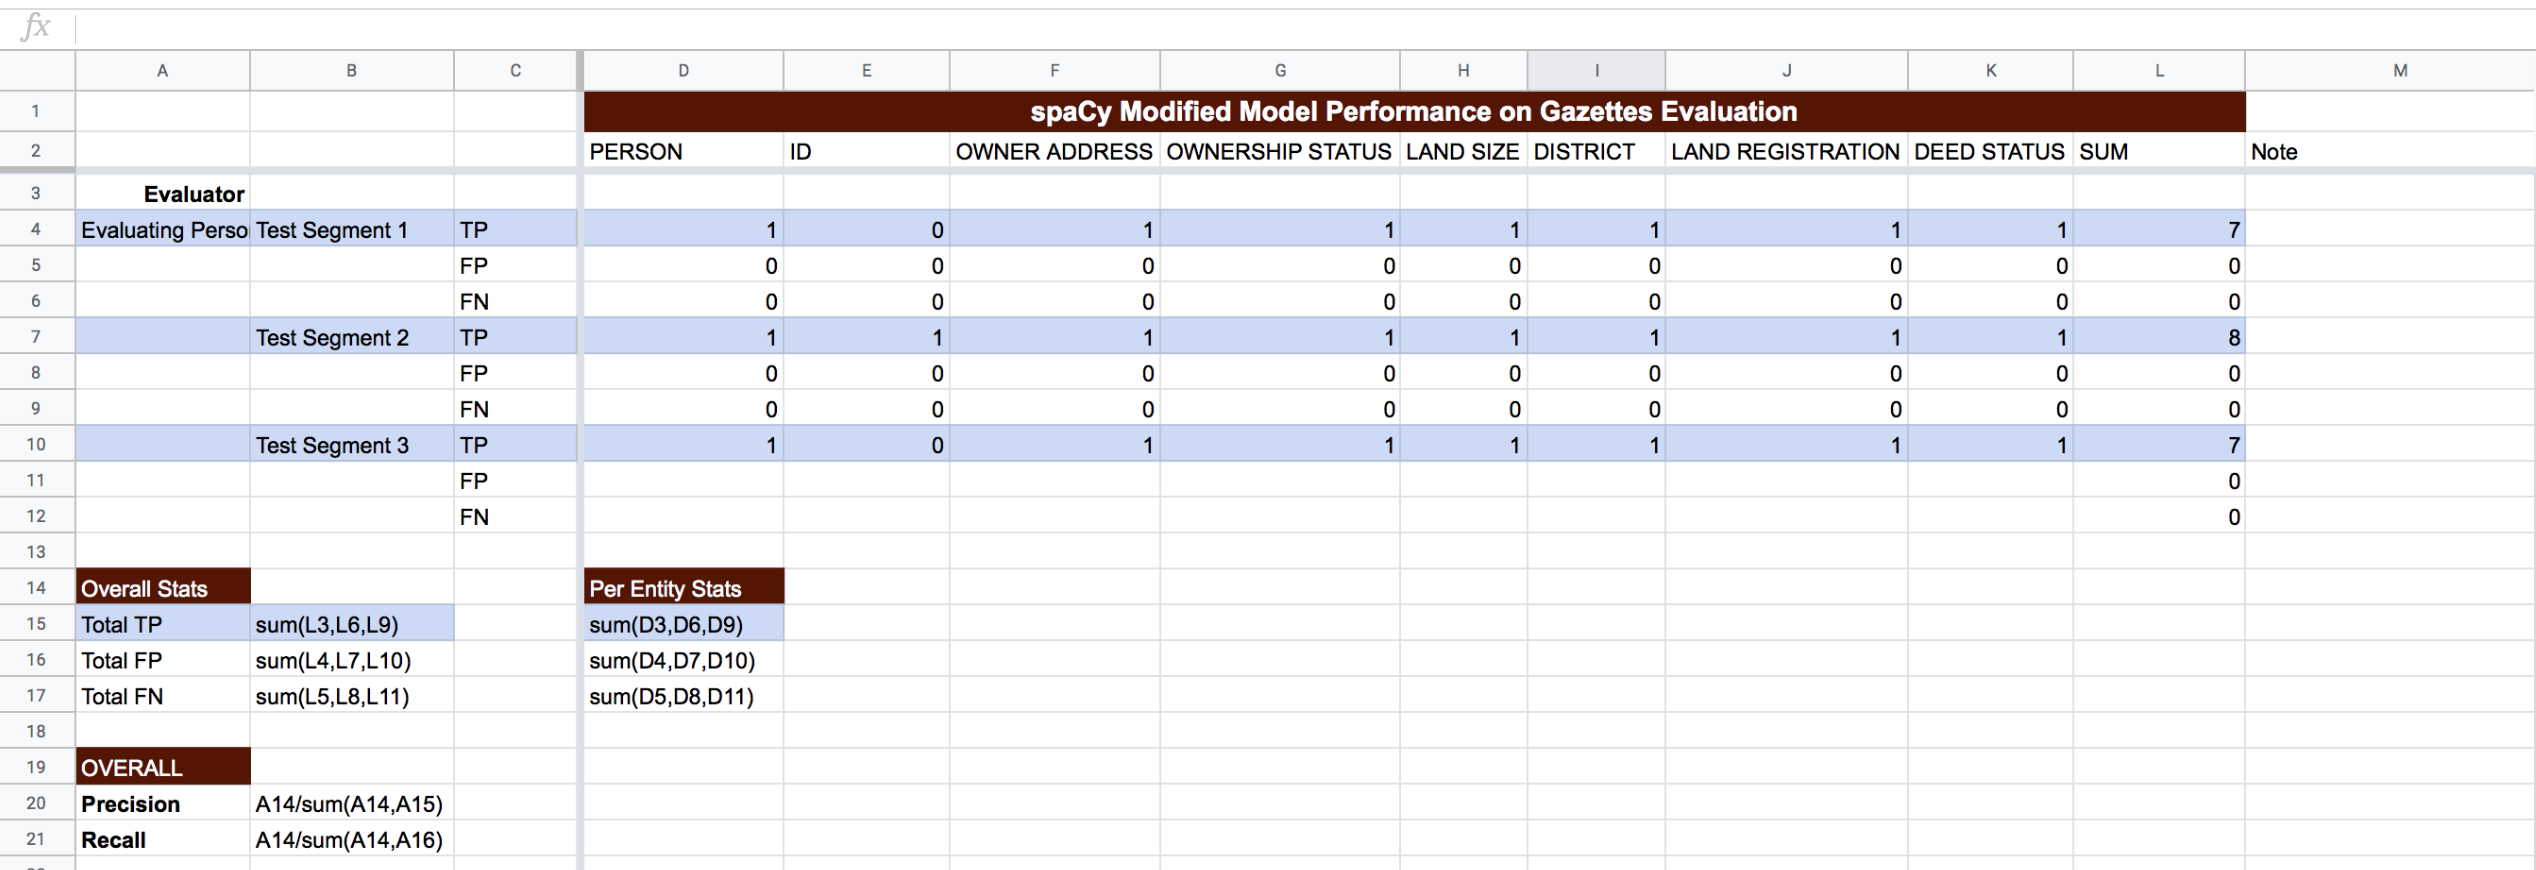

In [67]:
from PIL import Image

HOMEDIR = "/home/dssg-cfa/notebooks/dssg-cfa-public/C_build_ner_model/"
os.chdir(HOMEDIR)

Image.open("supporting_images/sample_spacy_model_test_table.png")


To proceed with the testing, we will first load the model from the directory it is stored in. We will then load a few training sets and visualize these training sets.



### Part I: Load The Model

In [8]:
# CHANGE DIRECTORY
import os

# The model is stored in this directory. Change it to the directory where your model is stored
local_output_dir = '/home/dssg-cfa/notebooks/dssg-cfa-public/C_build_ner_model/model_outputs/'
os.chdir(local_output_dir)


# LOAD THE Modified MODEL
import spacy

print("Loading from", local_output_dir)
modified_model = spacy.load(local_output_dir)

# LOAD The Default Model
print("Loading the default English model")
default_model = spacy.load("en_core_web_sm")

Loading from /home/dssg-cfa/notebooks/dssg-cfa-public/C_build_ner_model/model_outputs/
Loading the default English model


### Part II: Load Test Sets

The training sets should be gazette segments in a text format. The following chunck loads the gazettes as they are stored in our current structure. Feel free to change it to your desired destination that contains your gazette texts.

In [9]:
# Change this directory to the root of your folder that contains the modified labels ##TO CHANGE TO DO BEFORE FINAL
ROUTETOROOTDIR = '/home/dssg-cfa/notebooks/dssg-cfa-public/'
IMPORTSCRIPTSDIR = ROUTETOROOTDIR + "util/py_files/"

import os
os.chdir(IMPORTSCRIPTSDIR)
import trainingDataForSpaCy


# We used gazettes 30 - 110 as train data so we'll use the remaining as test data
num_test_gazettes = list(range(0,30)) + list(range(110, 150))

test_gazettes = []
for i in num_test_gazettes:
    test = trainingDataForSpaCy.exportTrainData(i)
    test_gazettes += test

/home/dssg-cfa/notebooks/dssg-cfa-public/C_build_ner_model
/home/dssg-cfa/notebooks/dssg-cfa-public
/home/dssg-cfa/notebooks
/home/dssg-cfa
/home
/


## Part III: Run The Test

We will vizualize the entities of a few randomly selected segments by running them through the default and the modified model to see the difference. We will use the `displacy` package in `spaCy` to visualize. We believe visualizing the entities and running a manual check is the best approach to assess the model performance since none of the models are absolutely reliable and humans can identify entities with relatively high accuracy. 

In [10]:
from spacy import displacy
import random

# Shuffle the num_test_gazettes to randomize the test

all_tests = list(range(len(test_gazettes)))
random.seed(3)
random.shuffle(all_tests)

Note that, in our current file structure, the test texts are stored at the following location `[for test in test_gazettes for text in test]`. Feel free to modify this according to your file structure.

**NOTE:** Stop the kernel shortly after the visualization is displayed on your monitor. By default, the kernel continues to run even after the display has been completed and this may affect your other performances. Stopping the Kernel has no negative impact on your visualization or model.

### Test 1: Modified

In [13]:
# Test 1
doc = modified_model(test_gazettes[all_tests[1]][0]) # The text of the test sets is stored at the 0th index.
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


### Test 1: Default

In [22]:
# Test 1
doc = default_model(test_gazettes[all_tests[1]][0]) # The text of the test sets is stored at the 0th index.
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


### Test 2: Modified

In [17]:
# Test 2
doc = modified_model(test_gazettes[all_tests[13]][0]) # The text of the test sets is stored at the 0th index.
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


### Test 2: Default

In [18]:
# Test 2
doc = default_model(test_gazettes[all_tests[13]][0]) # The text of the test sets is stored at the 0th index.
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


## Conclusion

One can continue to test more texts to further understand the performance of the model. Here is our takeaway from a test conducted on 20 randomly selected gazette sections.

**Strengths**

* As we can see from the above visualizations, the modified model better picks up on entities that are specific to the gazettes such as `LAND SIZE` AND `OWNER ADDRESS`. Overall, the model has a '0.97' Precision and '0.91' recall. We find this performance to be satisfactory.

Despite this strong performance, the model has some growth areas. To further understand the shortcomings of the model, we will evaluate the precision and recall for each entity and identify which entity is struggling.

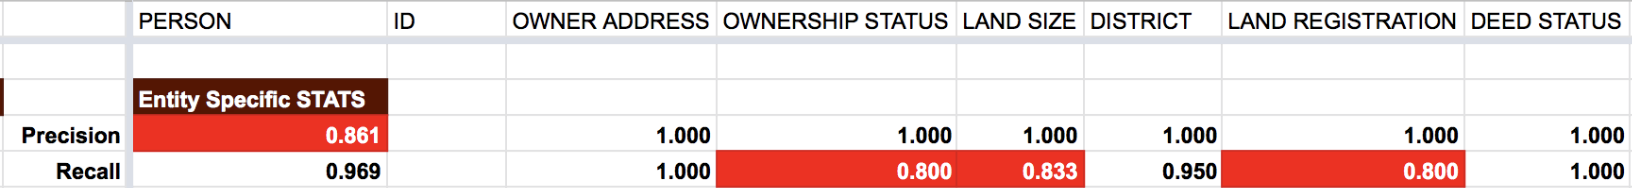

In [71]:
os.getcwd()
Image.open("supporting_images/spacy_model_per_entity_model_test.png")

Due to the shortcomings mentioned above, 

1. PERSON: The precision for `PERSON` is lower due to the high false positive rate. There is a high false positive rate for the labels `PERSON` and `ORG`.  Due to this skew, there will be entities wrongly identified as PERSON or ORG in the final network. For instance, title registration numbers of the form `L. R. XXXX` are usually classified as `PERSON`.

    * How to fix this: modify the training set regex to label `L. R. XXXX` as land registration number and include notices that have `L. R. XXXX` in the training set. This will give the model enough training examples to learn that `L. R. XXXX` is registration number and not person.

2. OWNERSHIP STATUS: The recall for `OWNERSHIP STATUS` is lower because the model fails to recognize the ownership status if the status only has the word `as proprietor` instead of `as proprietor in absolute ownership`.

    * How to fix this: modify the training set regex to label `as proprietor` as `OWNERSHIP STATUS` in addition `as proprietor in absolute ownership`.


3. Land size and land registration number: the model gets confused when there are multiple lands mentioned in one segment. For example, the text: "interest of all those pieces of land containing 0.70 CARDINAL and 0.67 CARDINAL hectare or thereabouts, situate in the district of Migori DISTRICT , registered under title numbers Kamagambo PERSON /Kabuoro/1057 and 1037" contains two lands and neither the land size nor the registration are recognized properly by the model.

    * How to fix this: the fix to this issue is not clear.

4. Punctuation: If there is a puntuation in a district (for example, `Murang'a`), the model identifies it as a GPE and if there is punctuation in the name, the model fails to recognize is as `PERSON`. 

    * How to fix this: modify the training set regex to allow for punctuation in names of individuals, organizations, as well as districts.

5. LAND REGISTRATION: The recall for `LAND REGISTRATION` is also lower due to some gazettes publishing abbreviated land registration numbers as `L. R.`.

    * How to fix this: See the fix for the `PERSON` label.

6. **OVERALL:** The model struggles to properly classify an entity if it is preceeded by `No.`. For instance, the model fails to recognize `land title No. XXXX` as `TITLE NUMBER`. However, the model recognizes it correctly if the phrase is `land title number XXXX`. 

    * How to fix this: preprocess the test text to replace `No.` by `number` before passing it to the model to extract entities.



### Next Steps

Going forward, we recommend a concentrated action to fix each of the six shotcomings mentioned above to further improve the NER modle.

In [72]:
## THE END